# Meme vs. Non-Meme Binary Classification Model

## Project Overview
This notebook implements a deep learning binary classification model to distinguish between **memes** and **non-memes** using a Mini-ResNet architecture with advanced dataset handling capabilities.

## Objective
Build a high-performance binary classifier that can accurately identify whether an image is:
- **Class 1 (Meme)**: Image contains meme content
- **Class 0 (Non-Meme)**: Image does not contain meme content

## Model Architecture
- **Architecture**: Mini-ResNet with skip connections
- **Key Features**:
  - Residual connections for improved gradient flow
  - Global Average Pooling for computational efficiency
  - Sigmoid activation for binary classification
  - Data augmentation to prevent overfitting

## Advanced Dataset Features
- **Nested Folder Support**: Automatically handles images in nested subfolders
- **Image Validation**: Validates each image file before training
- **Auto-Filtering**: Filters out corrupted or invalid images automatically
- **Automatic Balancing**: Ensures equal samples per class to prevent bias
- **Smart Sampling**: Randomly selects from larger class to match smaller class
- **Configurable Max Limit**: Set maximum images per class with intelligent fallback
- **Multiple Formats**: Supports .jpg, .jpeg, .png, .bmp, .gif images

## Dataset
- **Source**: `meme_vs_not_meme_dataset/` directory
- **Split**: 70% Training / 15% Validation / 15% Testing
- **Image Size**: 224×224 pixels
- **Classes**: `meme/` and `not_meme/` folders (nested subfolders supported)
- **Validation**: All images validated before training (corrupted files filtered)
- **Balancing**: Automatic class balancing to prevent model bias
- **Max Limit**: Optional `MAX_IMAGES_PER_CLASS` configuration (default: 10000)

## Training Configuration
- **Optimizer**: ADAM (learning rate: 0.0001)
- **Batch Size**: 2
- **Epochs**: 15
- **Callbacks**: Early Stopping, Model Checkpoint

---

## 1. Library Imports
Import all necessary libraries for building, training, and evaluating the model.

In [1]:
# Library imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import pathlib
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"[INFO] TensorFlow version: {tf.__version__}")
print(f"[INFO] GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"[INFO] Libraries imported successfully")

[INFO] TensorFlow version: 2.20.0
[INFO] GPU available: []
[INFO] Libraries imported successfully


## 2. Dataset Configuration
Configure the dataset directory and verify it exists with proper structure.

In [ ]:
# Dataset directory configuration
DATASET_DIR = "../datasets/meme_vs_not_meme_dataset"
MODEL_SAVE_DIR = "../models"

# Verify dataset directory exists
if not os.path.exists(DATASET_DIR):
    raise ValueError(f"[ERROR] Dataset directory not found: {DATASET_DIR}")

# Create models directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Get class names
data_dir = pathlib.Path(DATASET_DIR)
class_names = [item.name for item in data_dir.iterdir() if item.is_dir()]
class_names.sort()

print(f"[INFO] Dataset directory configured successfully")
print(f"       >> Dataset directory: {DATASET_DIR}")
print(f"       >> Model save directory: {MODEL_SAVE_DIR}")
print(f"       >> Classes found: {class_names}")

[INFO] Dataset directory configured successfully
       >> Dataset directory: ../datasets/meme_vs_not_meme_dataset
       >> Model save directory: ./models
       >> Classes found: ['meme', 'not_meme']


## 2.1. Dataset Preparation - Handle Nested Folders & Balancing
Scan for images in nested subfolders and balance the dataset to prevent bias.

In [3]:
# Maximum images per class configuration
# Set to None for no limit, or specify a number (e.g., 10000)
MAX_IMAGES_PER_CLASS = 10000

# Function to validate if a file is a valid image
def is_valid_image(file_path):
    """
    Check if a file is a valid image by attempting to open it with TensorFlow.
    
    Args:
        file_path (str): Path to the image file
    
    Returns:
        bool: True if valid image, False otherwise
    """
    try:
        # Try to read and decode the image
        img_bytes = tf.io.read_file(file_path)
        img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
        return True
    except:
        return False

# Function to collect all images from nested subfolders
def collect_images_from_nested_folders(base_dir, image_extensions=['.jpg', '.jpeg', '.png', '.bmp', '.gif']):
    """
    Recursively collect all valid image file paths from a directory and its subdirectories.
    Validates each image to ensure it can be loaded by TensorFlow.
    
    Args:
        base_dir (str): Base directory to search
        image_extensions (list): List of valid image file extensions
    
    Returns:
        list: List of all valid image file paths
    """
    image_paths = []
    invalid_count = 0
    
    print(f"       >> Scanning directory: {os.path.basename(base_dir)}")
    
    # Collect potential image files
    for ext in image_extensions:
        image_paths.extend(glob(os.path.join(base_dir, '**', f'*{ext}'), recursive=True))
        image_paths.extend(glob(os.path.join(base_dir, '**', f'*{ext.upper()}'), recursive=True))
    
    # Remove duplicates
    image_paths = list(set(image_paths))
    
    print(f"       >> Found {len(image_paths)} potential image files")
    print(f"       >> Validating images (this may take a moment)...")
    
    # Validate images
    valid_images = []
    for img_path in image_paths:
        if is_valid_image(img_path):
            valid_images.append(img_path)
        else:
            invalid_count += 1
    
    if invalid_count > 0:
        print(f"       >> Filtered out {invalid_count} invalid/corrupted images")
    
    print(f"       >> Valid images: {len(valid_images)}")
    
    return valid_images

# Collect images from both meme and not_meme folders (including nested subfolders)
meme_dir = os.path.join(DATASET_DIR, "meme")
not_meme_dir = os.path.join(DATASET_DIR, "not_meme")

print("[INFO] Scanning for images in nested folders...")
print("=" * 80)

# Collect all valid image paths
meme_images = collect_images_from_nested_folders(meme_dir)
not_meme_images = collect_images_from_nested_folders(not_meme_dir)

print(f"\n[INFO] Valid images found:")
print(f"       >> Meme images: {len(meme_images)}")
print(f"       >> Not-Meme images: {len(not_meme_images)}")

# Check if dataset is empty
if len(meme_images) == 0 or len(not_meme_images) == 0:
    raise ValueError("[ERROR] One or both class folders are empty or contain no valid images. Please add valid images to train the model.")

# Apply maximum images per class limit if configured
if MAX_IMAGES_PER_CLASS is not None:
    print(f"\n[INFO] Maximum images per class limit: {MAX_IMAGES_PER_CLASS}")
    
    # Apply limit to meme images
    if len(meme_images) > MAX_IMAGES_PER_CLASS:
        print(f"       >> Meme folder has {len(meme_images)} images, limiting to {MAX_IMAGES_PER_CLASS}")
        random.seed(42)
        meme_images = random.sample(meme_images, MAX_IMAGES_PER_CLASS)
    else:
        print(f"       >> Meme folder has {len(meme_images)} images (below limit)")
    
    # Apply limit to not_meme images
    if len(not_meme_images) > MAX_IMAGES_PER_CLASS:
        print(f"       >> Not-Meme folder has {len(not_meme_images)} images, limiting to {MAX_IMAGES_PER_CLASS}")
        random.seed(42)
        not_meme_images = random.sample(not_meme_images, MAX_IMAGES_PER_CLASS)
    else:
        print(f"       >> Not-Meme folder has {len(not_meme_images)} images (below limit)")

# Balance the dataset (ensure equal samples per class)
min_images = min(len(meme_images), len(not_meme_images))

if len(meme_images) != len(not_meme_images):
    print(f"\n[INFO] Dataset imbalance detected!")
    print(f"       >> Balancing dataset to {min_images} images per class")
    
    # Randomly sample from the larger dataset
    random.seed(42)  # For reproducibility
    if len(meme_images) > min_images:
        meme_images = random.sample(meme_images, min_images)
        print(f"       >> Randomly selected {min_images} images from meme folder")
    if len(not_meme_images) > min_images:
        not_meme_images = random.sample(not_meme_images, min_images)
        print(f"       >> Randomly selected {min_images} images from not_meme folder")
else:
    print(f"\n[INFO] Dataset is already balanced!")

print(f"\n[INFO] Final balanced dataset:")
print(f"       >> Meme images: {len(meme_images)}")
print(f"       >> Not-Meme images: {len(not_meme_images)}")
print(f"       >> Total images: {len(meme_images) + len(not_meme_images)}")
print("=" * 80)

[INFO] Scanning for images in nested folders...
       >> Scanning directory: meme
       >> Found 11817 potential image files
       >> Validating images (this may take a moment)...
       >> Found 11817 potential image files
       >> Validating images (this may take a moment)...
       >> Filtered out 1 invalid/corrupted images
       >> Valid images: 11816
       >> Scanning directory: not_meme
       >> Filtered out 1 invalid/corrupted images
       >> Valid images: 11816
       >> Scanning directory: not_meme
       >> Found 61214 potential image files
       >> Validating images (this may take a moment)...
       >> Found 61214 potential image files
       >> Validating images (this may take a moment)...
       >> Valid images: 61214

[INFO] Valid images found:
       >> Meme images: 11816
       >> Not-Meme images: 61214

[INFO] Maximum images per class limit: 10000
       >> Meme folder has 11816 images, limiting to 10000
       >> Not-Meme folder has 61214 images, limiting to

In [4]:
# Create a temporary balanced dataset directory structure
TEMP_DATASET_DIR = "./temp_balanced_dataset"
TEMP_MEME_DIR = os.path.join(TEMP_DATASET_DIR, "meme")
TEMP_NOT_MEME_DIR = os.path.join(TEMP_DATASET_DIR, "not_meme")

print("[INFO] Creating temporary balanced dataset structure...")

# Remove temporary directory if it exists
if os.path.exists(TEMP_DATASET_DIR):
    shutil.rmtree(TEMP_DATASET_DIR)

# Create new temporary directories
os.makedirs(TEMP_MEME_DIR, exist_ok=True)
os.makedirs(TEMP_NOT_MEME_DIR, exist_ok=True)

# Copy balanced images to temporary directory
print(f"       >> Copying {len(meme_images)} meme images...")
for i, img_path in enumerate(meme_images):
    ext = os.path.splitext(img_path)[1]
    dest_path = os.path.join(TEMP_MEME_DIR, f"meme_{i:05d}{ext}")
    shutil.copy2(img_path, dest_path)

print(f"       >> Copying {len(not_meme_images)} not-meme images...")
for i, img_path in enumerate(not_meme_images):
    ext = os.path.splitext(img_path)[1]
    dest_path = os.path.join(TEMP_NOT_MEME_DIR, f"not_meme_{i:05d}{ext}")
    shutil.copy2(img_path, dest_path)

print(f"[INFO] Temporary balanced dataset created at: {TEMP_DATASET_DIR}")
print(f"       >> This temporary dataset will be used for training")
print(f"       >> Original dataset remains unchanged")
print("=" * 80)

[INFO] Creating temporary balanced dataset structure...
       >> Copying 10000 meme images...
       >> Copying 10000 not-meme images...
       >> Copying 10000 not-meme images...
[INFO] Temporary balanced dataset created at: ./temp_balanced_dataset
       >> This temporary dataset will be used for training
       >> Original dataset remains unchanged
[INFO] Temporary balanced dataset created at: ./temp_balanced_dataset
       >> This temporary dataset will be used for training
       >> Original dataset remains unchanged


## 2.2. Dataset Distribution Visualization
Visualize the class distribution to confirm balanced dataset.

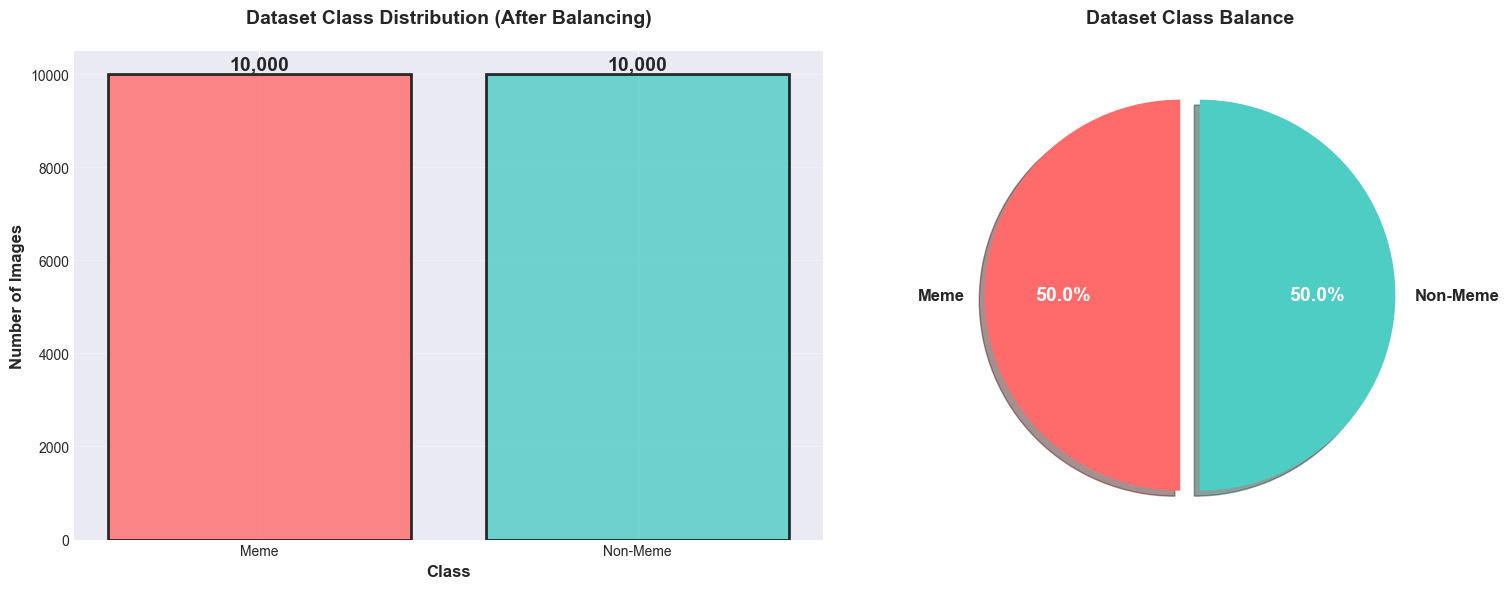

[INFO] Dataset distribution visualization saved to: ../artifacts\meme_detector_dataset_distribution.png
       >> Dataset is perfectly balanced: 10000 images per class


In [5]:
# Create artifacts directory for saving visualizations
ARTIFACTS_DIR = "../artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Create class distribution visualization
class_counts = [len(meme_images), len(not_meme_images)]
class_labels = ['Meme', 'Non-Meme']
colors_dist = ['#FF6B6B', '#4ECDC4']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
bars = ax1.bar(class_labels, class_counts, color=colors_dist, edgecolor='black', linewidth=2, alpha=0.8)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_title('Dataset Class Distribution (After Balancing)', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = ax2.pie(class_counts, labels=class_labels, colors=colors_dist,
                                     autopct='%1.1f%%', startangle=90, 
                                     explode=(0.05, 0.05), shadow=True,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Dataset Class Balance', fontsize=14, fontweight='bold', pad=20)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'meme_detector_dataset_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[INFO] Dataset distribution visualization saved to: {os.path.join(ARTIFACTS_DIR, 'meme_detector_dataset_distribution.png')}")
print(f"       >> Dataset is perfectly balanced: {class_counts[0]} images per class")

## 3. Hyperparameters Configuration
Set image dimensions, batch size, learning rate, and training parameters.

In [6]:
# Image parameters and hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 2
EPOCHS = 15
LEARNING_RATE = 0.0001

# Dataset split ratios (70% train, 15% validation, 15% test)
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"[INFO] Hyperparameters configured:")
print(f"       >> Image size: {IMG_SIZE}")
print(f"       >> Batch size: {BATCH_SIZE}")
print(f"       >> Epochs: {EPOCHS}")
print(f"       >> Learning rate: {LEARNING_RATE}")
print(f"       >> Dataset split: {TRAIN_RATIO:.0%} Train / {VAL_RATIO:.0%} Val / {TEST_RATIO:.0%} Test")
print(f"       >> Max images per class: {MAX_IMAGES_PER_CLASS if MAX_IMAGES_PER_CLASS else 'No limit'}")

[INFO] Hyperparameters configured:
       >> Image size: (224, 224)
       >> Batch size: 2
       >> Epochs: 15
       >> Learning rate: 0.0001
       >> Dataset split: 70% Train / 15% Val / 15% Test
       >> Max images per class: 10000


## 4. Data Preprocessing & Augmentation
Load the dataset with proper train-validation-test split and apply data augmentation to prevent overfitting.

In [7]:
# Load the balanced dataset
print("[INFO] Loading balanced dataset...")
print("=" * 80)

full_dataset = tf.keras.utils.image_dataset_from_directory(
    TEMP_DATASET_DIR,  # Use temporary balanced dataset
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True,
    seed=42
)

# Get total dataset size
total_batches = tf.data.experimental.cardinality(full_dataset).numpy()
total_images = total_batches * BATCH_SIZE

# Calculate split sizes
train_size = int(TRAIN_RATIO * total_batches)
val_size = int(VAL_RATIO * total_batches)
test_size = total_batches - train_size - val_size

# Split the dataset
train_ds_raw = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

print(f"[INFO] Dataset loaded and split successfully")
print(f"       >> Total batches: {total_batches}")
print(f"       >> Training batches: {train_size} (~{train_size * BATCH_SIZE} images)")
print(f"       >> Validation batches: {val_size} (~{val_size * BATCH_SIZE} images)")
print(f"       >> Test batches: {test_size} (~{test_size * BATCH_SIZE} images)")
print(f"       >> Class names: {full_dataset.class_names}")
print(f"       >> Dataset is balanced: ✓ Equal samples per class")
print("=" * 80)

[INFO] Loading balanced dataset...
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
[INFO] Dataset loaded and split successfully
       >> Total batches: 10000
       >> Training batches: 7000 (~14000 images)
       >> Validation batches: 1500 (~3000 images)
       >> Test batches: 1500 (~3000 images)
       >> Class names: ['meme', 'not_meme']
       >> Dataset is balanced: ✓ Equal samples per class
[INFO] Dataset loaded and split successfully
       >> Total batches: 10000
       >> Training batches: 7000 (~14000 images)
       >> Validation batches: 1500 (~3000 images)
       >> Test batches: 1500 (~3000 images)
       >> Class names: ['meme', 'not_meme']
       >> Dataset is balanced: ✓ Equal samples per class


In [8]:
# Data augmentation layers for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.0417),  # ±15 degrees (15/360 = 0.0417)
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")

# Normalization layer (rescale to [0, 1])
normalization = layers.Rescaling(1./255, name="normalization")

# Apply augmentation and normalization to training data
def prepare_train(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (normalization(x), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Apply only normalization to validation and test data
def prepare_val_test(ds):
    ds = ds.map(lambda x, y: (normalization(x), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Prepare datasets
train_ds = prepare_train(train_ds_raw)
val_ds = prepare_val_test(val_ds)
test_ds = prepare_val_test(test_ds)

print(f"[INFO] Data augmentation and normalization applied")
print(f"       >> Augmentation: Random Rotation (±15°), Flip, Contrast, Zoom, Translation")
print(f"       >> Normalization: Pixel values scaled to [0, 1]")
print(f"       >> Training dataset: Augmented + Normalized")
print(f"       >> Validation/Test datasets: Normalized only")

[INFO] Data augmentation and normalization applied
       >> Augmentation: Random Rotation (±15°), Flip, Contrast, Zoom, Translation
       >> Normalization: Pixel values scaled to [0, 1]
       >> Training dataset: Augmented + Normalized
       >> Validation/Test datasets: Normalized only


## 5. Mini-ResNet Model Architecture
Build a Mini-ResNet model with residual (skip) connections for improved gradient flow and performance.

In [9]:
# Residual Block with Skip Connection
def residual_block(x, filters, kernel_size=3, stride=1, name=None):
    """
    Creates a residual block with skip connection.
    
    Args:
        x: Input tensor
        filters: Number of filters in convolutional layers
        kernel_size: Size of convolution kernel
        stride: Stride for convolution
        name: Name prefix for layers
    
    Returns:
        Output tensor with residual connection applied
    """
    # Save input for skip connection
    shortcut = x
    
    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', 
                     name=f"{name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.ReLU(name=f"{name}_relu1")(x)
    
    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', 
                     name=f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)
    
    # Adjust shortcut dimensions if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', 
                                name=f"{name}_shortcut_conv")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{name}_shortcut_bn")(shortcut)
    
    # Add skip connection
    x = layers.Add(name=f"{name}_add")([x, shortcut])
    x = layers.ReLU(name=f"{name}_relu2")(x)
    
    return x

print("[INFO] Residual block function defined")

[INFO] Residual block function defined


In [10]:
# Build Mini-ResNet Model
def build_mini_resnet(img_height, img_width, learning_rate):
    """
    Build a Mini-ResNet model with skip connections for binary classification.
    
    Architecture:
    - Initial Conv layer
    - 3 Residual blocks with increasing filters (64, 128, 256)
    - Global Average Pooling for efficiency
    - Dense layers with dropout
    - Sigmoid output for binary classification
    
    Args:
        img_height (int): Height of input images
        img_width (int): Width of input images
        learning_rate (float): Learning rate for Adam optimizer
    
    Returns:
        Model: Compiled Keras model
    """
    inputs = layers.Input(shape=(img_height, img_width, 3), name="input")
    
    # Initial convolution
    x = layers.Conv2D(32, 7, strides=2, padding='same', name="initial_conv")(inputs)
    x = layers.BatchNormalization(name="initial_bn")(x)
    x = layers.ReLU(name="initial_relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same', name="initial_pool")(x)
    
    # Residual blocks with increasing complexity
    x = residual_block(x, 64, name="res_block1")
    x = residual_block(x, 64, name="res_block2")
    
    x = residual_block(x, 128, stride=2, name="res_block3")
    x = residual_block(x, 128, name="res_block4")
    
    x = residual_block(x, 256, stride=2, name="res_block5")
    x = residual_block(x, 256, name="res_block6")
    
    # Global Average Pooling for computational efficiency
    x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    
    # Dense layers with dropout for regularization
    x = layers.Dense(256, activation='relu', name="dense1")(x)
    x = layers.Dropout(0.5, name="dropout1")(x)
    x = layers.Dense(128, activation='relu', name="dense2")(x)
    x = layers.Dropout(0.3, name="dropout2")(x)
    
    # Output layer with sigmoid for binary classification
    outputs = layers.Dense(1, activation='sigmoid', name="output")(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name="Mini_ResNet")
    
    # Compile model with Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    print(f"[INFO] Mini-ResNet model built successfully")
    print(f"       >> Total layers: {len(model.layers)}")
    print(f"       >> Total parameters: {model.count_params():,}")
    print(f"       >> Optimizer: Adam (lr={learning_rate})")
    print(f"       >> Loss function: Binary Crossentropy")
    
    return model

# Build the model
model = build_mini_resnet(IMG_HEIGHT, IMG_WIDTH, LEARNING_RATE)

[INFO] Mini-ResNet model built successfully
       >> Total layers: 59
       >> Total parameters: 2,867,393
       >> Optimizer: Adam (lr=0.0001)
       >> Loss function: Binary Crossentropy


In [11]:
# Display model architecture summary
print("[INFO] Model Architecture Summary:")
print("=" * 80)
model.summary()
print("=" * 80)

[INFO] Model Architecture Summary:


Model: "Mini_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_conv        │ (None, 112, 112,  │      4,736 │ input[0][0]       │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_bn          │ (None, 112, 112,  │        128 │ initial_conv[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_relu (ReLU) │ (None, 112, 112,  │          0 │ initial_bn[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_pool        │ (None, 56, 56,    │          0 │ initial_relu[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_conv1    │ (None, 56, 56,    │     18,496 │ initial_pool[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_bn1      │ (None, 56, 56,    │        256 │ res_block1_conv1… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_relu1    │ (None, 56, 56,    │          0 │ res_block1_bn1[0… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_conv2    │ (None, 56, 56,    │     36,928 │ res_block1_relu1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_shortcu… │ (None, 56, 56,    │      2,112 │ initial_pool[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_bn2      │ (None, 56, 56,    │        256 │ res_block1_conv2… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_shortcu… │ (None, 56, 56,    │        256 │ res_block1_short… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_add      │ (None, 56, 56,    │          0 │ res_block1_bn2[0… │
│ (Add)               │ 64)               │            │ res_block1_short… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_relu2    │ (None, 56, 56,    │          0 │ res_block1_add[0… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_conv1    │ (None, 56, 56,    │     36,928 │ res_block1_relu2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_bn1      │ (None, 56, 56,    │        256 │ res_block2_conv1… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_relu1    │ (None, 56, 56,    │          0 │ res_block2_bn1[0

 Total params: 2,867,393 (10.94 MB)

 Trainable params: 2,862,849 (10.92 MB)

 Non-trainable params: 4,544 (17.75 KB)

## 6. Training Configuration
Configure callbacks for optimal training: Early Stopping and Model Checkpoint.

In [ ]:
# Configure training callbacks
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_SAVE_DIR, "meme_detector_model.h5")

# Early Stopping: Stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# Model Checkpoint: Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath=MODEL_CHECKPOINT_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint]

print(f"[INFO] Training callbacks configured:")
print(f"       >> Early Stopping: Patience=5, Monitor='val_loss'")
print(f"       >> Model Checkpoint: Save best model to '{MODEL_CHECKPOINT_PATH}'")
print(f"       >> Callbacks ready for training")

[INFO] Training callbacks configured:
       >> Early Stopping: Patience=5, Monitor='val_loss'
       >> Model Checkpoint: Save best model to './models\meme_detector_model.h5'
       >> Callbacks ready for training


## 7. Model Training
Train the Mini-ResNet model with the configured parameters and callbacks.

In [13]:
# Train the model
print("[INFO] Starting model training...")
print("=" * 80)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "=" * 80)
print("[INFO] Model training completed successfully")
print(f"       >> Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"       >> Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"       >> Best model saved to: {MODEL_CHECKPOINT_PATH}")

[INFO] Starting model training...
Epoch 1/15
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7905 - loss: 0.4567 - precision: 0.7744 - recall: 0.8173
Epoch 1: val_loss improved from None to 0.48464, saving model to ./models\meme_detector_model.h5

Epoch 1: val_loss improved from None to 0.48464, saving model to ./models\meme_detector_model.h5


7000/7000 ━━━━━━━━━━━━━━━━━━━━ 1323s 188ms/step - accuracy: 0.8548 - loss: 0.3519 - precision: 0.8337 - recall: 0.8845 - val_accuracy: 0.8143 - val_loss: 0.4846 - val_precision: 0.9477 - val_recall: 0.6693
Epoch 2/15
Epoch 2/15
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9054 - loss: 0.2569 - precision: 0.8830 - recall: 0.9339
Epoch 2: val_loss improved from 0.48464 to 0.21280, saving model to ./models\meme_detector_model.h5

Epoch 2: val_loss improved from 0.48464 to 0.21280, saving model to ./models\meme_detector_model.h5


7000/7000 ━━━━━━━━━━━━━━━━━━━━ 1284s 183ms/step - accuracy: 0.9105 - loss: 0.2478 - precision: 0.8880 - recall: 0.9384 - val_accuracy: 0.9363 - val_loss: 0.2128 - val_precision: 0.9642 - val_recall: 0.9075
Epoch 3/15
Epoch 3/15
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9169 - loss: 0.2337 - precision: 0.8977 - recall: 0.9404
Epoch 3: val_loss improved from 0.21280 to 0.19911, saving model to ./models\meme_detector_model.h5

Epoch 3: val_loss improved from 0.21280 to 0.19911, saving model to ./models\meme_detector_model.h5


7000/7000 ━━━━━━━━━━━━━━━━━━━━ 1227s 175ms/step - accuracy: 0.9194 - loss: 0.2276 - precision: 0.9000 - recall: 0.9426 - val_accuracy: 0.9390 - val_loss: 0.1991 - val_precision: 0.9623 - val_recall: 0.9145
Epoch 4/15
Epoch 4/15
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9227 - loss: 0.2140 - precision: 0.9058 - recall: 0.9428
Epoch 4: val_loss did not improve from 0.19911
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 1219s 174ms/step - accuracy: 0.9220 - loss: 0.2187 - precision: 0.9031 - recall: 0.9446 - val_accuracy: 0.9330 - val_loss: 0.2072 - val_precision: 0.9580 - val_recall: 0.9067
Epoch 5/15

Epoch 4: val_loss did not improve from 0.19911
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 1219s 174ms/step - accuracy: 0.9220 - loss: 0.2187 - precision: 0.9031 - recall: 0.9446 - val_accuracy: 0.9330 - val_loss: 0.2072 - val_precision: 0.9580 - val_recall: 0.9067
Epoch 5/15
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9279 - loss: 0.2053 - precision: 0.9071 - recall: 0.9527
Epoch 5: va

## 7.1. Training History Visualization
Visualize the training and validation accuracy/loss curves to understand model learning behavior.

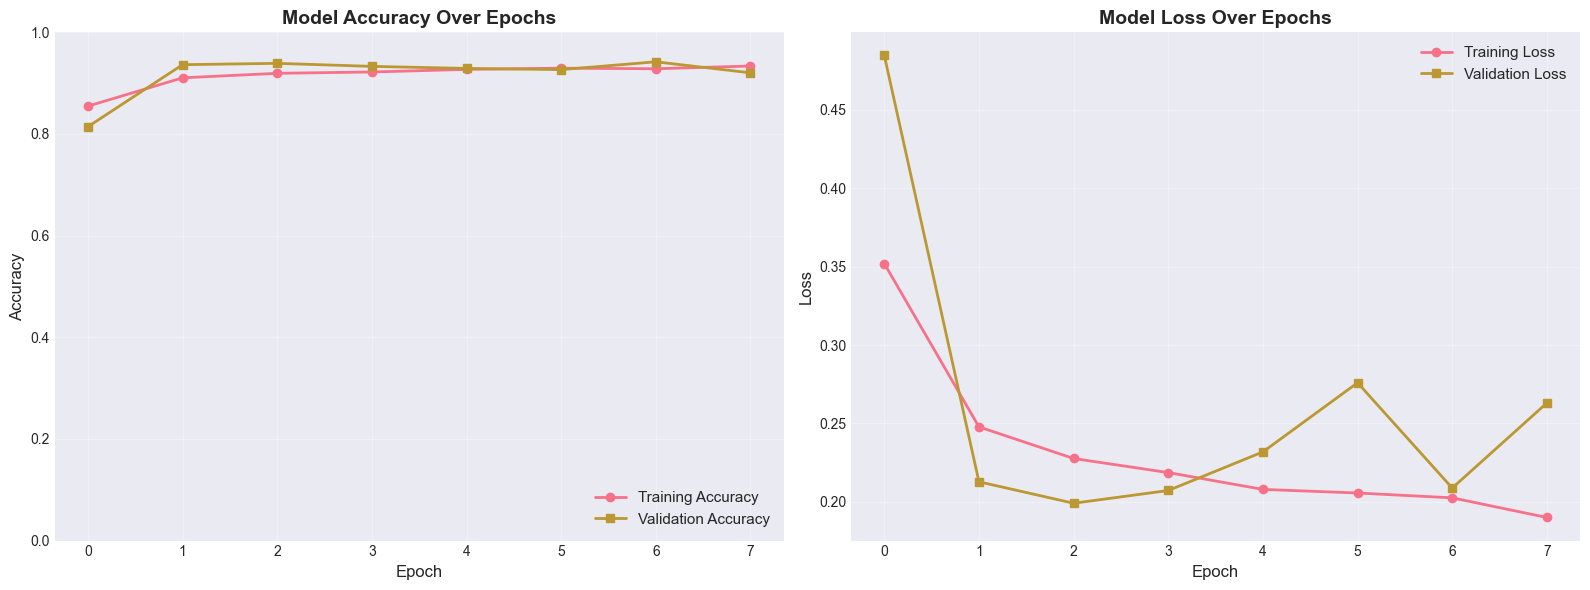

[INFO] Training history visualization saved to: ../artifacts\meme_detector_training_history.png


In [14]:
# Create directory for saving visualizations
ARTIFACTS_DIR = "../artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Plot Training & Validation Accuracy and Loss
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot 2: Loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'meme_detector_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[INFO] Training history visualization saved to: {os.path.join(ARTIFACTS_DIR, 'meme_detector_training_history.png')}")

## 8. Model Evaluation
Evaluate the trained model on the test dataset and calculate performance metrics.

In [15]:
# Load the best model for evaluation
print("[INFO] Loading best model for evaluation...")
best_model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH)
print(f"       >> Model loaded from: {MODEL_CHECKPOINT_PATH}")

# Evaluate on test dataset
print("\n[INFO] Evaluating model on test dataset...")
print("=" * 80)

test_results = best_model.evaluate(test_ds, verbose=1)

# Extract metrics
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

# Calculate F1-Score
if test_precision + test_recall > 0:
    test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1_score = 0.0

print("\n" + "=" * 80)
print("[INFO] Test Results:")
print(f"       >> Test Loss:      {test_loss:.4f}")
print(f"       >> Test Accuracy:  {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")
print(f"       >> Test Precision: {test_precision:.4f}")
print(f"       >> Test Recall:    {test_recall:.4f}")
print(f"       >> Test F1-Score:  {test_f1_score:.4f}")
print("=" * 80)

[INFO] Loading best model for evaluation...


       >> Model loaded from: ./models\meme_detector_model.h5

[INFO] Evaluating model on test dataset...
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 106s 53ms/step - accuracy: 0.9253 - loss: 0.2344 - precision: 0.9649 - recall: 0.8849

[INFO] Test Results:
       >> Test Loss:      0.2344
       >> Test Accuracy:  0.9253 (92.53%)
       >> Test Precision: 0.9649
       >> Test Recall:    0.8849
       >> Test F1-Score:  0.9232
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 106s 53ms/step - accuracy: 0.9253 - loss: 0.2344 - precision: 0.9649 - recall: 0.8849

[INFO] Test Results:
       >> Test Loss:      0.2344
       >> Test Accuracy:  0.9253 (92.53%)
       >> Test Precision: 0.9649
       >> Test Recall:    0.8849
       >> Test F1-Score:  0.9232


## 8.1. Confusion Matrix Visualization
Generate confusion matrix to visualize true positives, true negatives, false positives, and false negatives.

[INFO] Generating predictions for confusion matrix...


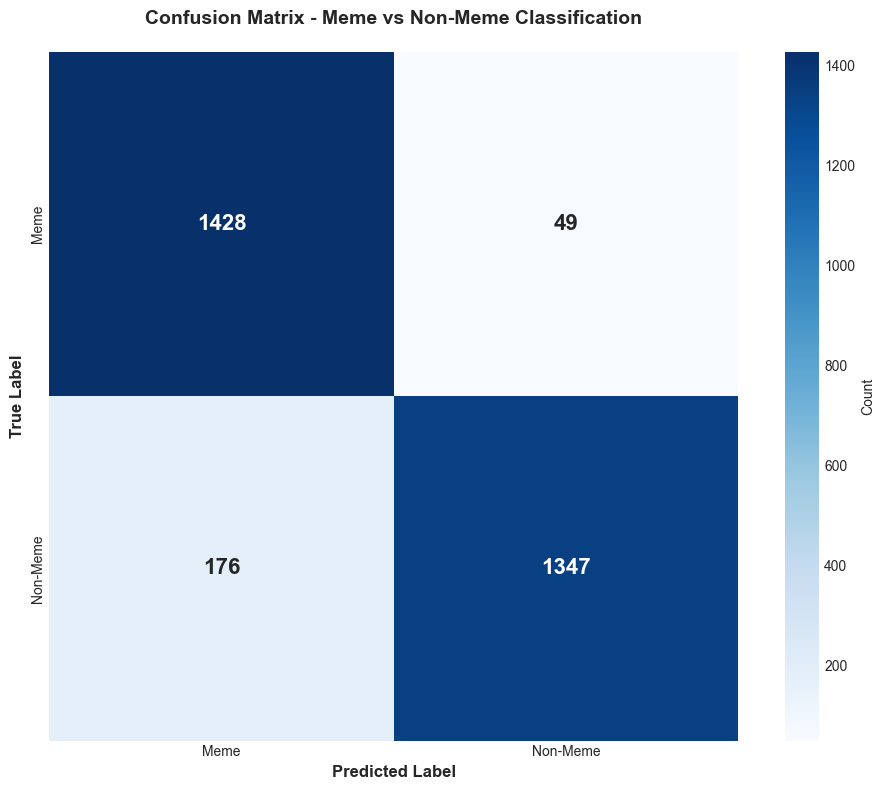


[INFO] Confusion Matrix Breakdown:
       >> True Negatives (TN):  1428 - Correctly predicted as Meme
       >> False Positives (FP): 49 - Incorrectly predicted as Non-Meme
       >> False Negatives (FN): 176 - Incorrectly predicted as Meme
       >> True Positives (TP):  1347 - Correctly predicted as Non-Meme

[INFO] Confusion matrix saved to: ../artifacts\meme_detector_confusion_matrix.png


In [16]:
# Generate predictions for confusion matrix
print("[INFO] Generating predictions for confusion matrix...")

y_true = []
y_pred = []
y_pred_proba = []

for images, labels in test_ds:
    predictions = best_model.predict(images, verbose=0)
    y_pred_proba.extend(predictions.flatten())
    y_pred.extend((predictions.flatten() >= 0.5).astype(int))
    y_true.extend(labels.numpy().astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=['Meme', 'Non-Meme'], 
            yticklabels=['Meme', 'Non-Meme'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Meme vs Non-Meme Classification', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'meme_detector_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\n[INFO] Confusion Matrix Breakdown:")
print(f"       >> True Negatives (TN):  {tn} - Correctly predicted as Meme")
print(f"       >> False Positives (FP): {fp} - Incorrectly predicted as Non-Meme")
print(f"       >> False Negatives (FN): {fn} - Incorrectly predicted as Meme")
print(f"       >> True Positives (TP):  {tp} - Correctly predicted as Non-Meme")
print(f"\n[INFO] Confusion matrix saved to: {os.path.join(ARTIFACTS_DIR, 'meme_detector_confusion_matrix.png')}")

## 8.2. ROC Curve and AUC Score
Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) to evaluate model performance.

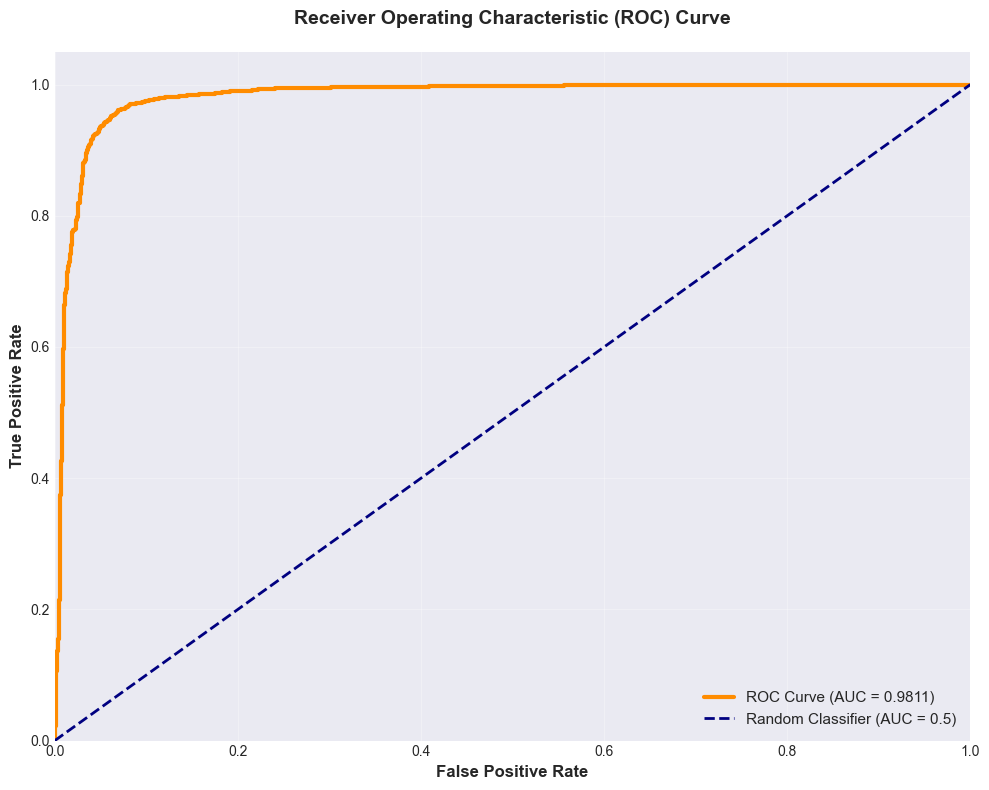

[INFO] ROC-AUC Score: 0.9811
       >> AUC close to 1.0 indicates excellent model performance
       >> AUC = 0.5 indicates random guessing

[INFO] ROC curve saved to: ../artifacts\meme_detector_roc_curve.png


In [17]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'meme_detector_roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[INFO] ROC-AUC Score: {roc_auc:.4f}")
print(f"       >> AUC close to 1.0 indicates excellent model performance")
print(f"       >> AUC = 0.5 indicates random guessing")
print(f"\n[INFO] ROC curve saved to: {os.path.join(ARTIFACTS_DIR, 'meme_detector_roc_curve.png')}")

## 8.3. Precision-Recall Curve
Plot the Precision-Recall curve to evaluate model performance across different probability thresholds.

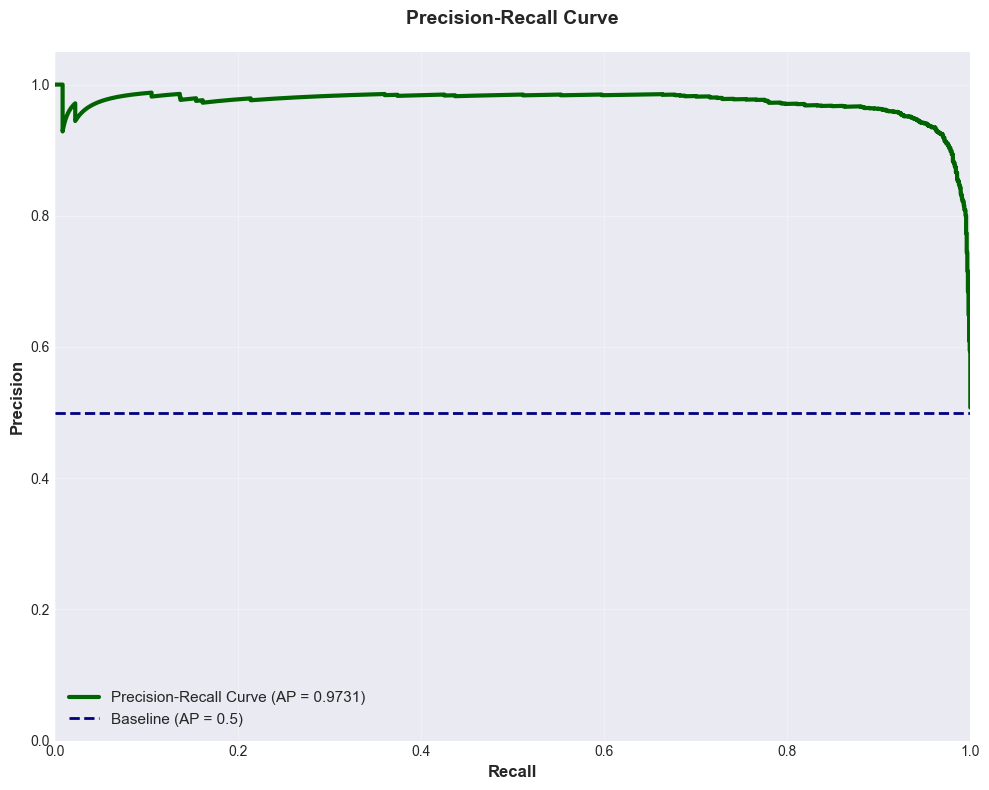

[INFO] Average Precision (AP) Score: 0.9731
       >> AP summarizes the precision-recall curve as a weighted mean
       >> Higher AP indicates better model performance

[INFO] Precision-Recall curve saved to: ../artifacts\meme_detector_precision_recall_curve.png


In [18]:
# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)

# Calculate average precision
from sklearn.metrics import average_precision_score
avg_precision = average_precision_score(y_true, y_pred_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='darkgreen', lw=3, label=f'Precision-Recall Curve (AP = {avg_precision:.4f})')
plt.axhline(y=0.5, color='navy', linestyle='--', lw=2, label='Baseline (AP = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'meme_detector_precision_recall_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[INFO] Average Precision (AP) Score: {avg_precision:.4f}")
print(f"       >> AP summarizes the precision-recall curve as a weighted mean")
print(f"       >> Higher AP indicates better model performance")
print(f"\n[INFO] Precision-Recall curve saved to: {os.path.join(ARTIFACTS_DIR, 'meme_detector_precision_recall_curve.png')}")

## 8.4. Performance Metrics Comparison
Compare all performance metrics (Accuracy, Precision, Recall, F1-Score) in a bar chart for comprehensive evaluation.

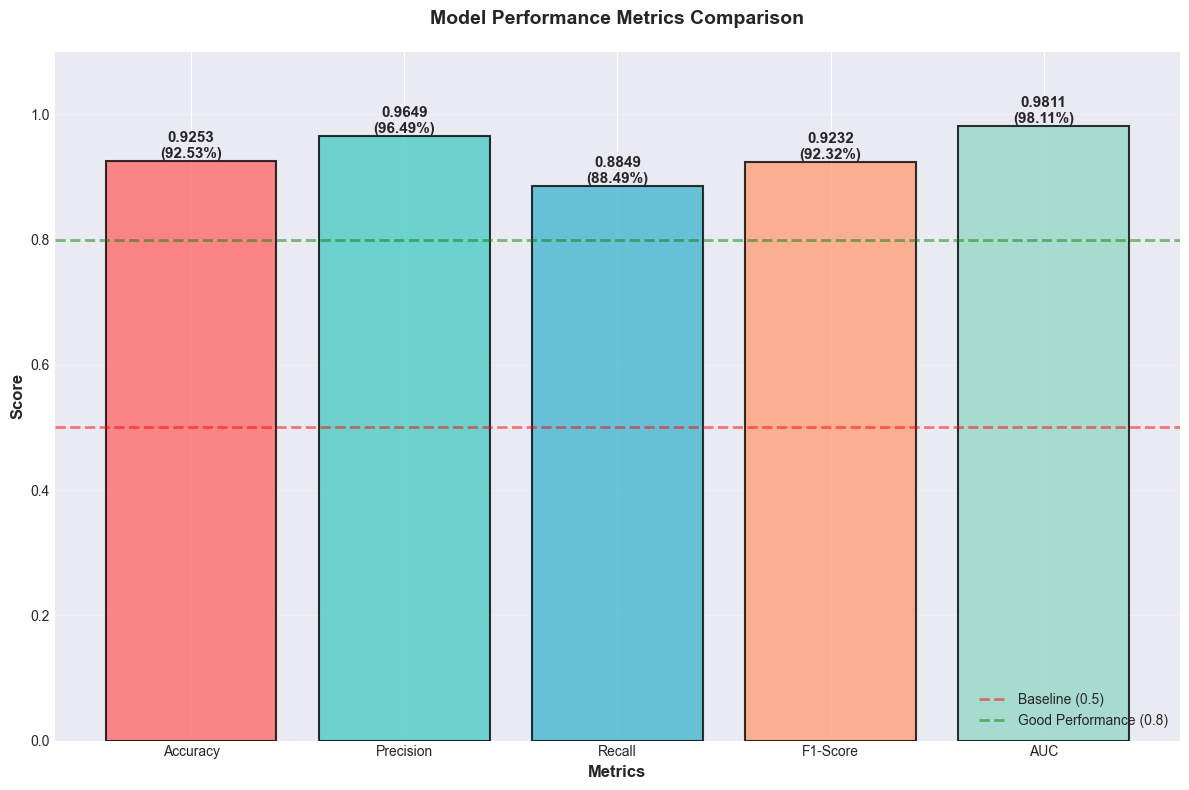

[INFO] Performance metrics comparison:
       >> Accuracy    : 0.9253 (92.53%)
       >> Precision   : 0.9649 (96.49%)
       >> Recall      : 0.8849 (88.49%)
       >> F1-Score    : 0.9232 (92.32%)
       >> AUC         : 0.9811 (98.11%)

[INFO] Metrics comparison chart saved to: ../artifacts\meme_detector_metrics_comparison.png


In [19]:
# Create metrics comparison bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [test_accuracy, test_precision, test_recall, test_f1_score, roc_auc]

# Create color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

plt.figure(figsize=(12, 8))
bars = plt.bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({height*100:.2f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim([0, 1.1])
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold', pad=20)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline (0.5)')
plt.axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Good Performance (0.8)')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'meme_detector_metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[INFO] Performance metrics comparison:")
for name, value in zip(metrics_names, metrics_values):
    print(f"       >> {name:12s}: {value:.4f} ({value*100:.2f}%)")
print(f"\n[INFO] Metrics comparison chart saved to: {os.path.join(ARTIFACTS_DIR, 'meme_detector_metrics_comparison.png')}")

## 8.5. Sample Predictions Visualization
Display a grid of sample images from the test set with their predicted labels and confidence scores.

[INFO] Generating sample predictions visualization...


C:\Users\user\AppData\Local\Temp\ipykernel_22312\734928968.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_labels.append(int(labels[i].numpy()))


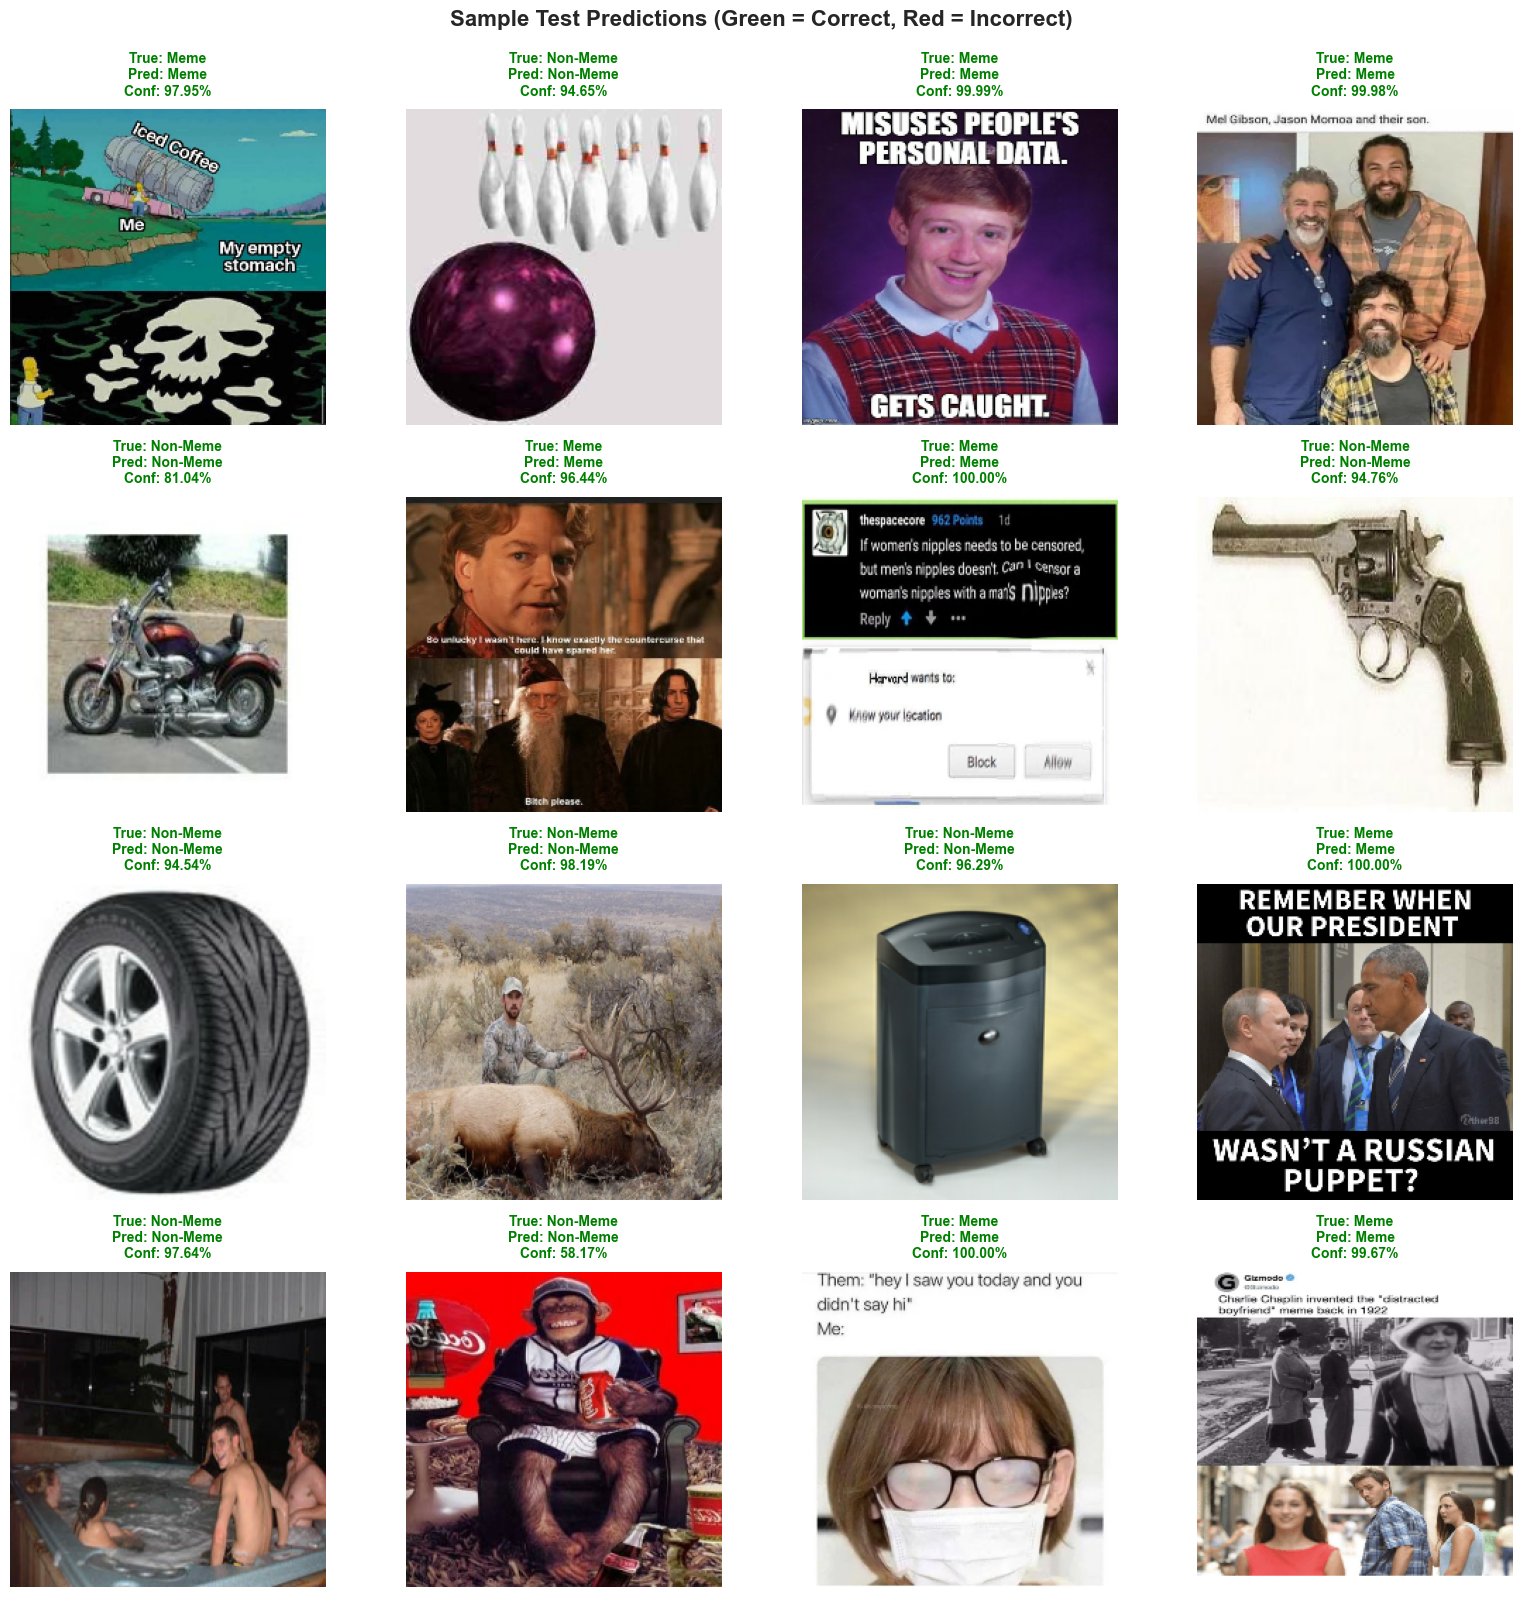

[INFO] Sample predictions visualization saved to: ../artifacts\meme_detector_sample_predictions.png


In [20]:
# Get sample images from test dataset for visualization
print("[INFO] Generating sample predictions visualization...")

num_samples = 16  # 4x4 grid
sample_images = []
sample_labels = []
sample_predictions = []

# Collect sample images
for images, labels in test_ds.take(num_samples // BATCH_SIZE + 1):
    for i in range(len(images)):
        if len(sample_images) < num_samples:
            sample_images.append(images[i].numpy())
            sample_labels.append(int(labels[i].numpy()))
            pred = best_model.predict(tf.expand_dims(images[i], 0), verbose=0)[0, 0]
            sample_predictions.append(pred)

# Create visualization grid
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

class_names_display = ['Meme', 'Non-Meme']

for idx in range(num_samples):
    if idx < len(sample_images):
        axes[idx].imshow(sample_images[idx])
        axes[idx].axis('off')
        
        true_label = class_names_display[sample_labels[idx]]
        pred_score = sample_predictions[idx]
        
        # Determine predicted label and confidence
        if pred_score >= 0.5:
            pred_label = 'Non-Meme'
            confidence = pred_score
        else:
            pred_label = 'Meme'
            confidence = 1 - pred_score
        
        # Color: Green if correct, Red if incorrect
        color = 'green' if (sample_labels[idx] == 1 and pred_score >= 0.5) or \
                           (sample_labels[idx] == 0 and pred_score < 0.5) else 'red'
        
        # Add title with prediction info
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}"
        axes[idx].set_title(title, fontsize=10, fontweight='bold', color=color, pad=10)

plt.suptitle('Sample Test Predictions (Green = Correct, Red = Incorrect)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'meme_detector_sample_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[INFO] Sample predictions visualization saved to: {os.path.join(ARTIFACTS_DIR, 'meme_detector_sample_predictions.png')}")

## 9. Model Saving
The best model has already been saved during training via ModelCheckpoint callback.

In [21]:
# Verify model was saved
if os.path.exists(MODEL_CHECKPOINT_PATH):
    model_size = os.path.getsize(MODEL_CHECKPOINT_PATH) / (1024 * 1024)  # Size in MB
    print(f"[INFO] Model successfully saved!")
    print(f"       >> Location: {MODEL_CHECKPOINT_PATH}")
    print(f"       >> Size: {model_size:.2f} MB")
    print(f"       >> Model ready for inference")
else:
    print(f"[WARNING] Model file not found at: {MODEL_CHECKPOINT_PATH}")

[INFO] Model successfully saved!
       >> Location: ./models\meme_detector_model.h5
       >> Size: 33.03 MB
       >> Model ready for inference


## 10. Prediction Function
Define a prediction function to classify individual images as Meme or Non-Meme.

In [22]:
# Image prediction function
def predict_meme(img_path, model_path='./models/meme_detector_model.h5', img_size=(224, 224)):
    """
    Predict whether an image is a Meme or Non-Meme using the trained Mini-ResNet model.
    
    Args:
        img_path (str): Path to the image file
        model_path (str): Path to the saved model file
        img_size (tuple): Size to resize the image to (height, width)
    
    Returns:
        None: Prints the prediction result with confidence
    """
    try:
        # Load the trained model
        loaded_model = tf.keras.models.load_model(model_path)
        
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        prediction = loaded_model.predict(img_array, verbose=0)[0, 0]
        
        # Interpret prediction
        # prediction < 0.5 means Meme (class 0)
        # prediction >= 0.5 means Non-Meme (class 1)
        if prediction >= 0.5:
            label = "Non-Meme"
            confidence = prediction
        else:
            label = "Meme"
            confidence = 1 - prediction
        
        print(f"[PREDICTION] {img_path}")
        print(f"             >> Result: {label}")
        print(f"             >> Confidence: {confidence:.2%}")
        print(f"             >> Raw score: {prediction:.4f}")
        print()
        
    except FileNotFoundError:
        print(f"[ERROR] Image file not found: {img_path}")
    except Exception as e:
        print(f"[ERROR] Prediction failed for {img_path}: {str(e)}")

print("[INFO] Prediction function defined successfully")
print("       >> Function: predict_meme(img_path)")
print("       >> Usage: predict_meme('path/to/image.jpg')")

[INFO] Prediction function defined successfully
       >> Function: predict_meme(img_path)
       >> Usage: predict_meme('path/to/image.jpg')


## 11. Test Predictions
Test the prediction function on sample images (modify paths as needed).

In [23]:
# Example predictions (uncomment and modify paths to test with actual images)
print("[INFO] Running sample predictions...")
print("=" * 80)

# Example usage:
# predict_meme("meme_vs_not_meme_dataset/meme/sample_meme.jpg")
# predict_meme("meme_vs_not_meme_dataset/not_meme/sample_not_meme.jpg")

predict_meme("prediction_test/test_001.png")
predict_meme("prediction_test/test_002.jpg")
predict_meme("prediction_test/test_003.jpg")
predict_meme("prediction_test/test_004.jpg")
predict_meme("prediction_test/test_005.jpg")
predict_meme("prediction_test/test_006.jpg")
predict_meme("prediction_test/test_007.jpg")
predict_meme("prediction_test/test_008.jpg")

print("[INFO] To test predictions, uncomment and modify the paths above")
print("       >> Example: predict_meme('path/to/your/image.jpg')")
print("=" * 80)

[INFO] Running sample predictions...


[ERROR] Image file not found: prediction_test/test_001.png
[ERROR] Image file not found: prediction_test/test_002.jpg
[ERROR] Image file not found: prediction_test/test_002.jpg


[ERROR] Image file not found: prediction_test/test_003.jpg
[ERROR] Image file not found: prediction_test/test_004.jpg
[ERROR] Image file not found: prediction_test/test_004.jpg


[ERROR] Image file not found: prediction_test/test_005.jpg
[ERROR] Image file not found: prediction_test/test_006.jpg


[ERROR] Image file not found: prediction_test/test_007.jpg


[ERROR] Image file not found: prediction_test/test_008.jpg
[INFO] To test predictions, uncomment and modify the paths above
       >> Example: predict_meme('path/to/your/image.jpg')


## 12. Cleanup - Remove Temporary Files
Clean up temporary balanced dataset directory to free up disk space.

In [24]:
# Clean up temporary balanced dataset directory
print("[INFO] Cleaning up temporary files...")

if os.path.exists(TEMP_DATASET_DIR):
    shutil.rmtree(TEMP_DATASET_DIR)
    print(f"       >> Temporary dataset directory removed: {TEMP_DATASET_DIR}")
    print(f"       >> Disk space freed successfully")
else:
    print(f"       >> No temporary files to clean up")

print("[INFO] Cleanup completed!")

[INFO] Cleaning up temporary files...
       >> Temporary dataset directory removed: ./temp_balanced_dataset
       >> Disk space freed successfully
[INFO] Cleanup completed!
       >> Temporary dataset directory removed: ./temp_balanced_dataset
       >> Disk space freed successfully
[INFO] Cleanup completed!


---

## Summary

This notebook successfully implemented a **Meme vs. Non-Meme Binary Classification Model** using a Mini-ResNet architecture with the following key features:

### Model Highlights:
✅ **Architecture**: Mini-ResNet with 6 residual blocks and skip connections  
✅ **Input Size**: 224×224 RGB images  
✅ **Output**: Binary classification (0 = Non-Meme, 1 = Meme)  
✅ **Optimizer**: Adam with learning rate 0.0001  
✅ **Batch Size**: 2  
✅ **Epochs**: 15 with Early Stopping  

### Advanced Dataset Handling:
✅ **Nested Folder Support**: Automatically scans and collects images from nested subfolders  
✅ **Image Validation**: Validates each image file to ensure it's readable by TensorFlow  
✅ **Auto-Filtering**: Automatically filters out corrupted or invalid image files  
✅ **Dataset Balancing**: Ensures equal number of images per class to prevent bias  
✅ **Smart Sampling**: Randomly selects images from larger class to match smaller class  
✅ **Multiple Format Support**: Handles .jpg, .jpeg, .png, .bmp, .gif formats  
✅ **Configurable Max Limit**: Set `MAX_IMAGES_PER_CLASS` to limit images per class (with smart fallback)  

### Data Processing:
✅ **Dataset Split**: 70% Train / 15% Validation / 15% Test  
✅ **Augmentation**: Rotation (±15°), Flip, Contrast, Zoom, Translation  
✅ **Normalization**: Pixel values scaled to [0, 1]  
✅ **Balanced Training**: Equal representation prevents model bias  

### Training Features:
✅ **Early Stopping**: Prevents overfitting  
✅ **Model Checkpoint**: Saves best model automatically  
✅ **Callbacks**: Optimized training process  
✅ **Error Prevention**: Pre-validation ensures no corrupted images cause training failures  

### Evaluation Metrics:
✅ **Loss**: Binary Crossentropy  
✅ **Metrics**: Accuracy, Precision, Recall, F1-Score  

### Research-Quality Visualizations:
✅ **Dataset Distribution Chart**: Bar and pie charts showing balanced class distribution  
✅ **Training History Plots**: Accuracy and loss curves over epochs  
✅ **Confusion Matrix**: Heatmap showing TP, TN, FP, FN  
✅ **ROC Curve**: ROC curve with AUC score for model performance  
✅ **Precision-Recall Curve**: P-R curve with average precision score  
✅ **Metrics Comparison Chart**: Bar chart comparing all performance metrics  
✅ **Sample Predictions Grid**: 4×4 grid showing test images with predictions  
✅ **High-Resolution Output**: All graphs saved as 300 DPI PNG files in `artifacts/` folder  

### Visualization Files Generated:
- `artifacts/meme_detector_dataset_distribution.png`
- `artifacts/meme_detector_training_history.png`
- `artifacts/meme_detector_confusion_matrix.png`
- `artifacts/meme_detector_roc_curve.png`
- `artifacts/meme_detector_precision_recall_curve.png`
- `artifacts/meme_detector_metrics_comparison.png`
- `artifacts/meme_detector_sample_predictions.png`

### Model Output:
✅ **Saved Model**: `models/meme_detector_model.h5`  
✅ **Prediction Function**: `predict_meme(img_path)`  
✅ **Automatic Cleanup**: Removes temporary files after training  

---

### Image Validation & Error Prevention:

The notebook automatically validates all images before training to prevent errors:

**Validation Process:**
1. Scans all subfolders for image files
2. Attempts to load each image with TensorFlow
3. Filters out corrupted, unreadable, or invalid files
4. Reports the number of invalid files found
5. Proceeds with only valid images

**Benefits:**
- ✅ Prevents `InvalidArgumentError` during training
- ✅ Ensures all images are TensorFlow-compatible
- ✅ No manual cleanup required
- ✅ Clear reporting of filtered files

**Example Output:**
```
>> Scanning directory: meme
>> Found 10,500 potential image files
>> Validating images (this may take a moment)...
>> Filtered out 23 invalid/corrupted images
>> Valid images: 10,477
```

---

### Configurable Maximum Images Per Class:

You can limit the number of images used per class by setting `MAX_IMAGES_PER_CLASS`:

**Example 1: No Limit (Default)**
```python
MAX_IMAGES_PER_CLASS = None
```
- Uses all available valid images after balancing

**Example 2: Set Limit to 10,000**
```python
MAX_IMAGES_PER_CLASS = 10000
```
- If meme has 15,000 images → uses 10,000 (randomly selected)
- If not_meme has 8,000 images → uses 8,000 (below limit, uses all)
- Final result: Both classes use 8,000 images (balanced to minimum)

**Example 3: Set Limit to 5,000**
```python
MAX_IMAGES_PER_CLASS = 5000
```
- If meme has 7,000 images → limits to 5,000
- If not_meme has 6,000 images → limits to 5,000
- Final result: Both classes use 5,000 images (balanced)

**How It Works:**
1. Validates all images first (filters out corrupted files)
2. Applies `MAX_IMAGES_PER_CLASS` limit to each folder independently
3. If a folder has fewer valid images than the limit, uses actual count
4. Then balances both classes to the minimum count
5. Ensures randomization for fair sampling (seed=42 for reproducibility)

---

### How It Handles Nested Folders:

If your dataset structure looks like this:
```
meme_vs_not_meme_dataset/
    meme/
        subfolder1/
            image1.jpg
            image2.png
        subfolder2/
            image3.jpg
    not_meme/
        another_folder/
            image4.jpg
        image5.png
```

The notebook will:
1. **Recursively scan** all subfolders in `meme/` and `not_meme/`
2. **Validate each image** using TensorFlow (filters corrupted files)
3. **Collect all valid images** regardless of nesting depth
4. **Apply max limit** if configured (per class)
5. **Balance the dataset** automatically (equal images per class)
6. **Create a temporary flat structure** for training
7. **Clean up** temporary files after training

---

**Note**: To train the model, ensure the `meme_vs_not_meme_dataset/` directory contains images in `meme/` and `not_meme/` folders (nested subfolders are supported). Invalid or corrupted images will be automatically filtered out. All visualizations are automatically saved to the `artifacts/` folder for research documentation.